In [2]:
%reload_ext autoreload

%autoreload 2


In [21]:
input_file = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/20220607_153923_MP-LFC-MS1var-OT-S1-120kMS1_Report.tsv"
directlfq_file = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/20220607_153923_MP-LFC-MS1var-OT-S1-120kMS1_Report.tsv.protein_intensities.tsv"

spectronaut_protein_intensities = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/20220607_153923_MP-LFC-MS1var-OT-S1-120kMS1_Report.tsv.spectronaut_protein.aq_reformat.tsv"
iq_protein_intensities = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/spectronaut_largefc_set_iq-MaxLFQ-fast.txt"

protein_mapping_file = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/organism_map.tsv"
samplemap  = "../../test_data/system_tests/Spectronaut_LargeFC/re_run_SN15/samplemap.tsv"

run_directlfq = True

In [4]:
if run_directlfq:
    import directlfq.lfq_manager as lfqmgr

    lfqmgr.run_lfq(input_file=input_file)



using input type spectronaut_fragion_isotopes
prot 100 of 7121
prot 200 of 7121
prot 300 of 7121
prot 400 of 7121
prot 500 of 7121
prot 600 of 7121
prot 700 of 7121
prot 800 of 7121
prot 900 of 7121
prot 1000 of 7121
prot 1100 of 7121
prot 1200 of 7121
prot 1300 of 7121
prot 1400 of 7121
prot 1500 of 7121
prot 1600 of 7121
prot 1700 of 7121
prot 1800 of 7121
prot 1900 of 7121
prot 2000 of 7121
prot 2100 of 7121
prot 2200 of 7121
prot 2300 of 7121
prot 2400 of 7121
prot 2500 of 7121
prot 2600 of 7121
prot 2700 of 7121
prot 2800 of 7121
prot 2900 of 7121
prot 3000 of 7121
prot 3100 of 7121
prot 3200 of 7121
prot 3300 of 7121
prot 3400 of 7121
prot 3500 of 7121
prot 3600 of 7121
prot 3700 of 7121
prot 3800 of 7121
prot 3900 of 7121
prot 4000 of 7121
prot 4100 of 7121
prot 4200 of 7121
prot 4300 of 7121
prot 4400 of 7121
prot 4500 of 7121
prot 4600 of 7121
prot 4700 of 7121
prot 4800 of 7121
prot 4900 of 7121
prot 5000 of 7121
prot 5100 of 7121
prot 5200 of 7121
prot 5300 of 7121
prot 5400

In [17]:
import directlfq.benchmarking as lfqbenchmark
import directlfq.utils as lfqutils


samples_used = lfqutils.get_samples_used_from_samplemap_file(samplemap, cond1="S1", cond2="S2")





restable_directlfq = lfqbenchmark.ResultsTableDirectLFQ(input_file=directlfq_file, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_iq = lfqbenchmark.ResultsTableDirectLFQ(input_file=iq_protein_intensities, input_name="iq", samples_c1=samples_used[0], samples_c2=samples_used[1])

restable_spectronaut = lfqbenchmark.ResultsTableDirectLFQ(input_file=spectronaut_protein_intensities, input_name="Spectronaut", samples_c1=samples_used[0], samples_c2=samples_used[1])

/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:151: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:151: RuntimeWarning: invalid value encountered in double_scalars
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:151: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:

In [18]:
display(restable_iq.formated_dataframe)
display(restable_directlfq.formated_dataframe)
display(restable_spectronaut.formated_dataframe)

,protein,MaxLFQ_annotation,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R01.raw,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R02.raw,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R03.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R01.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R02.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R03.raw,median_intensity_c1,median_intensity_c2,log2fc,mean_intensity
0,A0A024RBG1;Q9NZJ9,NaN,11.732290,11.985941,12.102513,11.685464,11.720836,12.000104,11.985941,11.720836,0.032268,11.853388
1,A0A061ACH4;A0A061ACK7;A0A061ADS3;A0A061AKN1;Q9...,NaN,11.022887,11.553229,11.314907,11.487261,11.733201,11.488689,11.314907,11.488689,-0.021990,11.401798
2,A0A061ACL3;O76618;Q965I6,NaN,11.722880,11.618996,11.334973,12.132965,12.062105,12.008104,11.618996,12.062105,-0.053996,11.840551
3,A0A061ACM2;A0A061ACP8;A0A061ADW6;A0A4V0IJW4;A0...,NaN,12.459725,12.550377,12.361485,12.945573,12.963603,12.777818,12.459725,12.945573,-0.055187,12.702649
4,A0A061ACN9;D3YT33;H9G2T6;H9G2T7;H9G2U2;H9G2U6;...,NaN,10.988638,10.815987,10.842005,11.422200,11.471298,11.364729,10.842005,11.422200,-0.075209,11.132103
...,...,...,...,...,...,...,...,...,...,...,...,...
7116,Q20128,NaN,NaN,NaN,7.061842,8.197953,8.845508,8.703445,7.061842,8.703445,-0.301542,7.882644
7117,Q22412,NaN,NaN,NaN,7.881096,8.300762,NaN,8.408215,7.881096,8.354488,-0.084155,8.117792
7118,Q5JS54,NaN,NaN,NaN,12.264978,11.280986,11.246808,12.017899,12.264978,11.280986,0.120651,11.772982
7119,O16000,NaN,NaN,NaN,NaN,7.979557,7.475720,8.675774,NaN,7.979557,NaN,7.979557


,protein,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R01.raw,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R02.raw,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R03.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R01.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R02.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R03.raw,median_intensity_c1,median_intensity_c2,log2fc,mean_intensity
0,A0A024RBG1;Q9NZJ9,1.206878e+06,1.855808e+06,1.899488e+06,1.403822e+06,1.378954e+06,1.527059e+06,1.855808e+06,1.403822e+06,0.402687,1.629815e+06
1,A0A061ACH4;A0A061ACK7;A0A061ADS3;A0A061AKN1;Q9...,4.613570e+05,7.735258e+05,6.269836e+05,7.277869e+05,7.008128e+05,6.608188e+05,6.269836e+05,7.008128e+05,-0.160601,6.638982e+05
2,A0A061ACL3;O76618;Q965I6,1.336116e+07,1.281200e+07,1.137953e+07,1.633705e+07,1.669973e+07,1.512836e+07,1.281200e+07,1.633705e+07,-0.350651,1.457453e+07
3,A0A061ACM2;A0A061ACP8;A0A061ADW6;A0A4V0IJW4;A0...,2.343997e+07,2.294939e+07,1.944248e+07,2.992402e+07,2.885128e+07,2.555183e+07,2.294939e+07,2.885128e+07,-0.330180,2.590033e+07
4,A0A061ACN9;D3YT33;H9G2T6;H9G2T7;H9G2U2;H9G2U6;...,6.073713e+06,5.459395e+06,5.769783e+06,7.578091e+06,7.737037e+06,7.481242e+06,5.769783e+06,7.578091e+06,-0.393317,6.673937e+06
...,...,...,...,...,...,...,...,...,...,...,...
7114,Q9ZZX0,8.620766e+05,8.751291e+05,5.709453e+05,7.611861e+05,8.705228e+05,6.694328e+05,8.620766e+05,7.611861e+05,0.179567,8.116313e+05
7115,U4PBU8;U4PMA7,5.783813e+06,4.902936e+06,5.777598e+06,6.970306e+06,6.782498e+06,6.892267e+06,5.777598e+06,6.892267e+06,-0.254509,6.334932e+06
7116,V6CJ04,1.973729e+06,2.606367e+06,3.090479e+06,3.319392e+06,3.359947e+06,2.505002e+06,2.606367e+06,3.319392e+06,-0.348879,2.962879e+06
7117,V6CLG8,3.424308e+06,3.403699e+06,2.407207e+06,4.077669e+06,4.538901e+06,4.078542e+06,3.403699e+06,4.078542e+06,-0.260950,3.741121e+06


,protein,ion,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R01.raw,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R02.raw,MP-LFC-MS1var-OT-S1-120kMS1_MHRM_R03.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R01.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R02.raw,MP-LFC-MS1var-OT-S2-120kMS1_MHRM_R03.raw,median_intensity_c1,median_intensity_c2,log2fc,mean_intensity
0,A0A024RBG1;Q9NZJ9,Homo sapiens,11040.935547,12845.580078,12518.584961,10368.327148,10473.362305,11901.716797,12518.584961,10473.362305,0.257347,11495.973633
1,A0A061ACH4;A0A061ACK7;A0A061ADS3;A0A061AKN1;Q9...,Caenorhabditis elegans,6765.349609,8766.033203,8466.593750,10077.818359,10159.820312,9703.391602,8466.593750,10077.818359,-0.251330,9272.206055
2,A0A061ACL3;O76618;Q965I6,Caenorhabditis elegans,39246.550781,38669.238281,35643.292969,52579.699219,45207.894531,46741.085938,38669.238281,46741.085938,-0.273505,42705.162109
3,A0A061ACM2;A0A061ACP8;A0A061ADW6;A0A4V0IJW4;A0...,Caenorhabditis elegans,80118.921875,78047.906250,67354.859375,92823.710938,96329.062500,89854.265625,78047.906250,92823.710938,-0.250133,85435.808594
4,A0A061ACN9;D3YT33;H9G2T6;H9G2T7;H9G2U2;H9G2U6;...,Caenorhabditis elegans,14135.708008,13181.861328,13499.753906,17830.500000,18272.027344,17125.343750,13499.753906,17830.500000,-0.401414,15665.126953
...,...,...,...,...,...,...,...,...,...,...,...,...
7116,Q9ZZX0,Saccharomyces cerevisiae (strain ATCC 204508 /...,17350.511719,18000.199219,13372.541016,15820.599609,17274.261719,15919.657227,17350.511719,15919.657227,0.124169,16635.084473
7117,U4PBU8;U4PMA7,Caenorhabditis elegans,9837.798828,8932.250977,9458.841797,11440.498047,11372.197266,13160.885742,9458.841797,11440.498047,-0.274414,10449.669922
7118,V6CJ04,Caenorhabditis elegans,4460.493652,4434.903320,4820.964844,6792.934570,5563.380859,4338.534180,4460.493652,5563.380859,-0.318758,5011.937256
7119,V6CLG8,Caenorhabditis elegans,35436.242188,37106.984375,30451.382812,44482.316406,49781.164062,48839.996094,35436.242188,48839.996094,-0.462837,42138.119141


In [19]:
organism_annotator_spectronaut_based = lfqbenchmark.OrganismAnnotatorSpectronaut(mapping_file=protein_mapping_file,protein_column="PG.ProteinGroups", organism_column="PG.Organisms")
organism_annotator_spectronaut_based.annotate_table_with_organism(restable_directlfq)
organism_annotator_spectronaut_based.annotate_table_with_organism(restable_spectronaut)
organism_annotator_spectronaut_based.annotate_table_with_organism(restable_iq)


In [22]:
organism_annotator_spectronaut_based.save_protein_organism_map(protein_mapping_file)

/Users/constantin/opt/anaconda3/envs/directLFQ/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/constantin/opt/anaconda3/envs/directLFQ/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-2.0, 2.0)

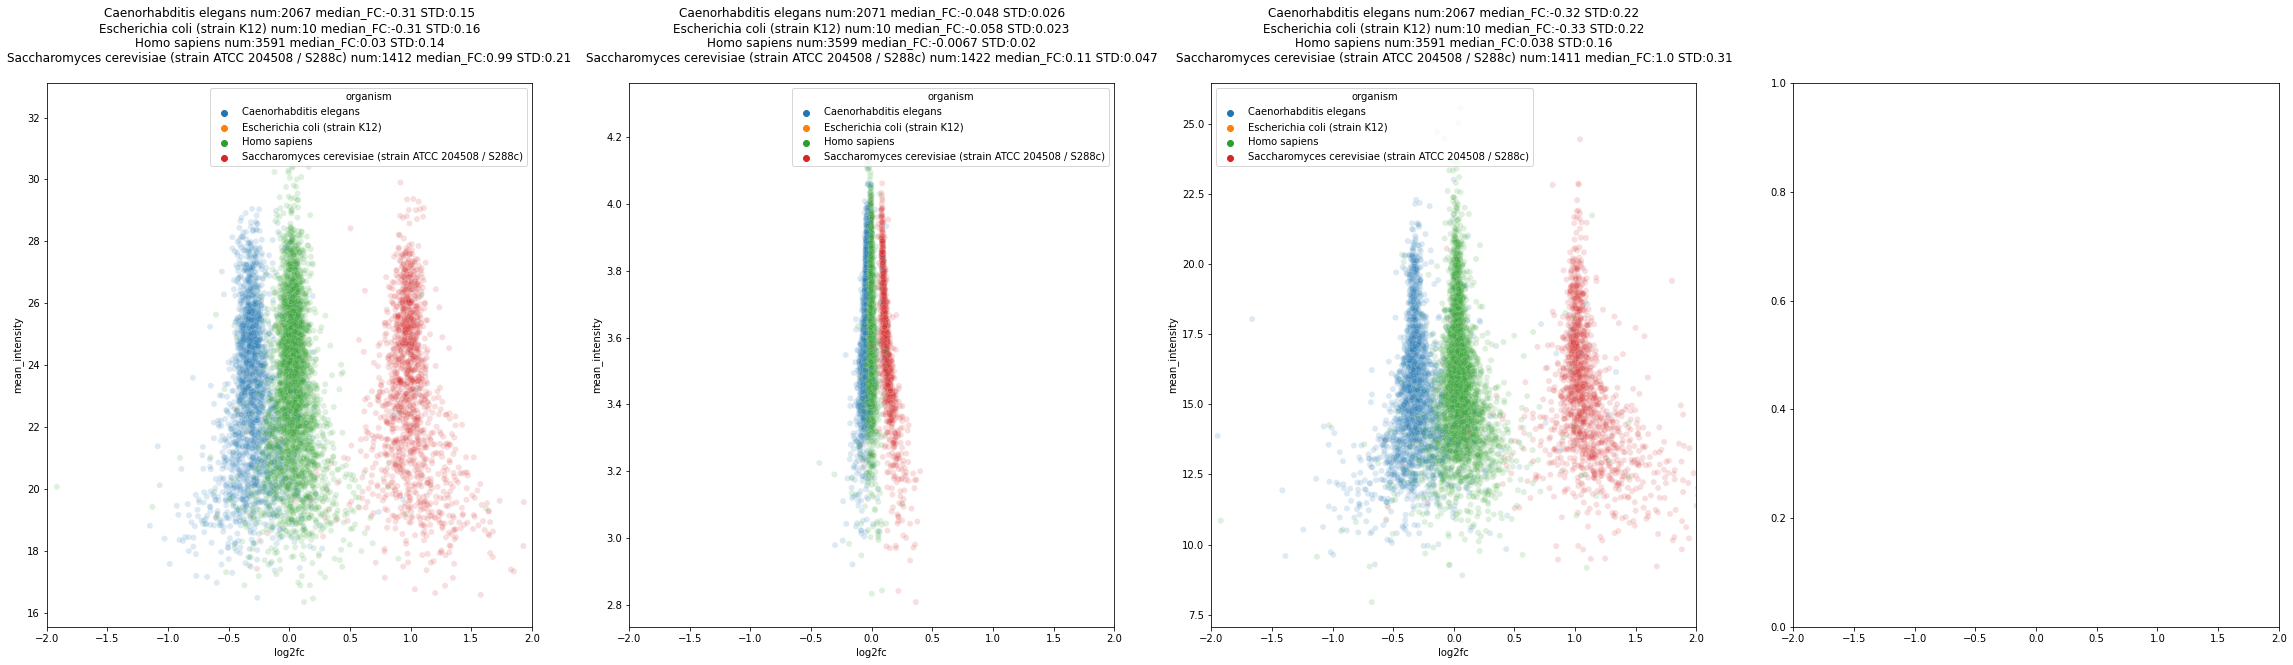

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4,figsize=(40,10))


fcplotter_directLFQ = lfqbenchmark.MultiOrganismIntensityFCPlotter(ax=axes[0], resultstable_w_ratios=restable_directlfq)

fcplotter_iq = lfqbenchmark.MultiOrganismIntensityFCPlotter(ax=axes[1], resultstable_w_ratios=restable_iq)
fcplotter_spectronaut = lfqbenchmark.MultiOrganismIntensityFCPlotter(ax=axes[2], resultstable_w_ratios= restable_spectronaut)


axes[0].set_xlim([-2, 2])
# axes[0].set_ylim([15, 33])
axes[1].set_xlim([-2, 2])
# axes[1].set_ylim([17, 35])
axes[2].set_xlim([-2, 2])
axes[3].set_xlim([-2, 2])


In [17]:
import pandas as pd

df = pd.read_csv(iq_protein_intensities, sep = "\t")
df = df.rename(columns={"Unnamed: 1" : "PG.Organisms", "PG.ProteinGroups" : 'protein'})
display(df)
df.to_csv(iq_protein_intensities, sep = "\t", index = None)

,protein,PG.Organisms,MaxLFQ_annotation,Fig3_MP-DIA-multi-organism-Run-S1_MHRM_R01_T0.htrms,Fig3_MP-DIA-multi-organism-Run-S1_MHRM_R02_T0.htrms,Fig3_MP-DIA-multi-organism-Run-S1_MHRM_R03_T0.htrms,Fig3_MP-DIA-multi-organism-Run-S2_MHRM_R01_T0.htrms,Fig3_MP-DIA-multi-organism-Run-S2_MHRM_R02_T0.htrms,Fig3_MP-DIA-multi-organism-Run-S2_MHRM_R03_T0.htrms
0,A0A061ACH4;A0A061ACK7;A0A061ADS3;A0A061AKN1;Q9...,Caenorhabditis elegans,NaN,12.127803,11.882431,11.733627,12.021682,11.879373,12.039310
1,A0A061ACL3;O76618;Q965I6,Caenorhabditis elegans,NaN,13.351426,13.242046,13.116774,13.445374,13.361346,13.224162
2,A0A061ACR1;F5GUA3;Q22498;Q2XN02,Caenorhabditis elegans,NaN,13.229293,13.162792,13.105977,13.364202,13.329408,13.369481
3,A0A061ACS9;G5EBE2;G5EBY2;G5EE94;K8ESB8;K8ESI6;...,Caenorhabditis elegans,NaN,13.938539,10.768114,10.963477,12.147541,11.194874,11.896805
4,A0A061ACU2;A0A061AE33;A0A061AJB7;A0A061AL01;A0...,Caenorhabditis elegans,NaN,12.074812,11.770226,9.735762,12.134015,11.259072,11.381226
...,...,...,...,...,...,...,...,...,...
11358,V6CIS4;V6CJX7;V6CL74;V6CLA2,Caenorhabditis elegans,NaN,12.855932,12.735977,12.699250,12.900718,12.850991,12.834572
11359,V6CJ04;V6CK55,Caenorhabditis elegans,NaN,12.797411,12.844344,12.750720,12.968550,12.898574,12.871459
11360,W6RQY9;W6RY35,Caenorhabditis elegans,NaN,11.401853,11.072112,11.164880,11.487700,11.225318,11.529686
11361,W6RTA4;W6SB91,Caenorhabditis elegans,NaN,14.735985,14.401953,14.200512,14.958911,14.617228,14.403746
